In [1]:
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install -U colabgymrender
!pip install imageio==2.4.1
!pip install gym[toy_text]


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for colabgymrender: filename=colabgymrender-1.1.0-py3-none-any.whl size=3132 sha256=2067dfd03090f3e847f838645824430e097a62b274adcc4495a0b0ed4ef92def
  Stored in directory: /root/.cache/pip/wheels/f1/0a/2a/86955ea711b461ab7918236fed2568733f75ed677d0524b56c
Successfully built colabgymrender
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.3 MB 5.2 MB/s 
  Created wheel for imageio: filename=imageio-2.4.1-py3-none-any.whl size=3303885 sha256=348912f971f58918d492a3de219fbfc62423a0ac4079d4ec141abb70447009ab
  Stored in directory: /root/.cache/pip/wheels/46/20/07/7bb9c8c44e6ec2efa60fd0e6280094f53f65f41767ef69a5ee
Successfully built imageio
  Attempting uninstall: imageio
    Found existing installation: imageio 2.9.0
    Uninstalling imageio-2.9.0:
      Successfully uninstalled imageio-2

In [2]:
# Setup Environment
import gym
from colabgymrender.recorder import Recorder
from typing import List, Set, Dict, Tuple, Optional
import numpy as np
from tqdm import tqdm
import os 
import numpy.ma as ma
from numpy.core.getlimits import inf
from collections import defaultdict
from gym.spaces import Space, Discrete
import random 
import matplotlib.pyplot as plt

os.environ["SDL_VIDEODRIVER"] = "dummy"

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2514944/45929032 bytes (5.5%)5775360/45929032 bytes (12.6%)9117696/45929032 bytes (19.9%)12263424/45929032 bytes (26.7%)15417344/45929032 bytes (33.6%)17981440/45929032 bytes (39.2%)20299776/45929032 bytes (44.2%)22511616/45929032 bytes (49.0%)25042944/45929032 bytes (54.5%)27746304/45929032 bytes (60.4%)31096832/45929032 bytes (67.7%)33554432/45929032 bytes (73.1%)

policy evaluation 

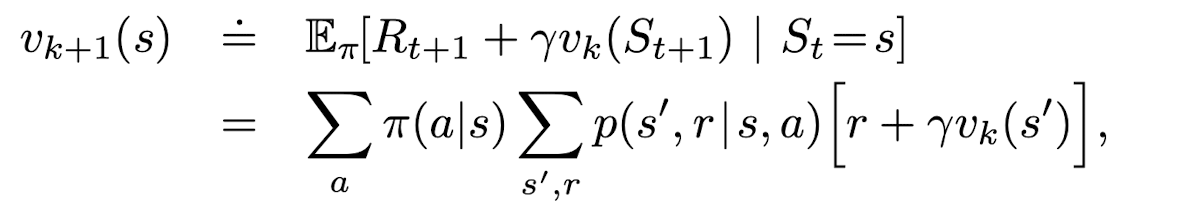

Policy Improvement

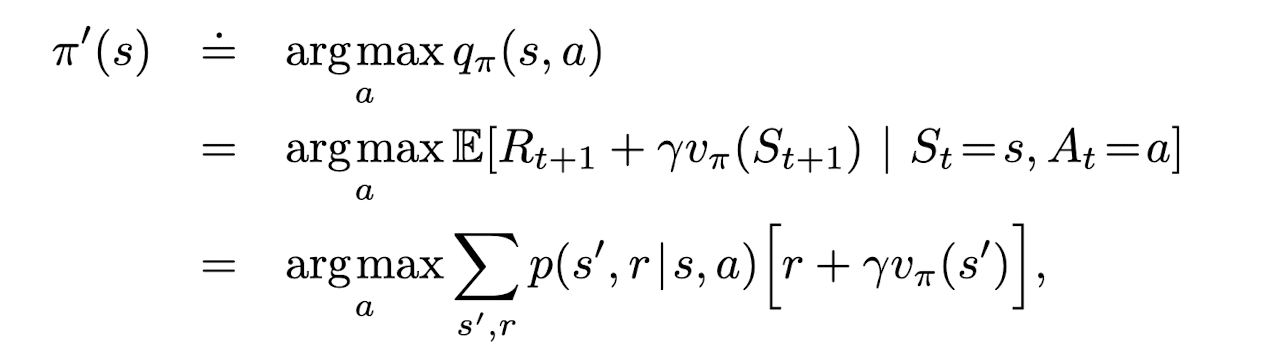

value iteration
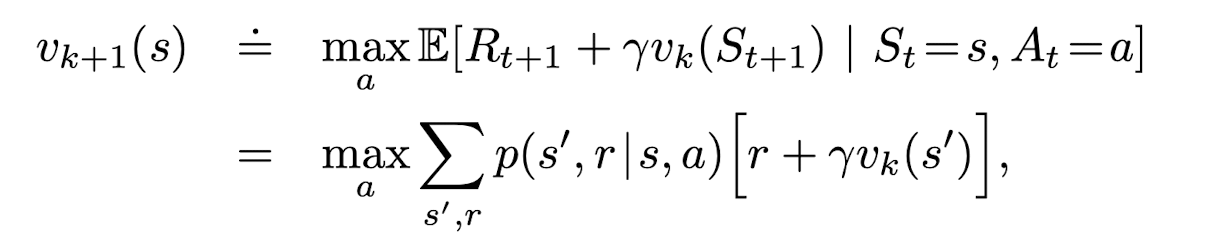

In [3]:
class Agent(object):
  def __init__(self, state_space: Space, action_space: Space):
    self._observiation_space = state_space
    self._action_space = action_space
    self._prev_action = None
    self._prev_state= None

  def take_action(self, state):
    pass

In [4]:
class PolicyIterationAgent(Agent):
  def __init__(self, state_space: Discrete, action_space: Discrete, discount_rate: float):
    super().__init__(state_space, state_space)
    self._num_state = state_space.n
    self._num_action = action_space.n
    self._state_values = np.full((state_space.n), 0.0)
    self._policy = np.full((state_space.n, action_space.n), 1.0 / action_space.n) 
    self._discount_rate = discount_rate

  # Find state values.
  def policy_evaluation(self, env_dynamic: np.array, threshold):
    converged = False
    terminal_states = [self._num_state-1]
    while not converged:
      max_delta = 0.0
      for s in range(self._num_state):
        if s in terminal_states:
          continue
        new_state_value = 0.0
        for a in range(self._num_action):
          # for i-th possible env dynamic p(s', r | s, a):
          for i in range(len(env_dynamic[s][a])):
            new_state = env_dynamic[s][a][i][1]
            reward = env_dynamic[s][a][i][2]
            p_sr_sa = env_dynamic[s][a][i][0]
            new_state_value += self._policy[s][a] * p_sr_sa * (reward + self._discount_rate * self._state_values[new_state])
        max_delta = max(abs(new_state_value - self._state_values[s]), max_delta)
        converged = max_delta < threshold
        # update state values
        self._state_values[s] = new_state_value

  # Find policy.
  def policy_improvement(self, env_dynamic: np.array) -> bool:
    policy_stable = True
    for s in range(self._num_state):
      action_values = []
      for a in range(self._num_action):
        # for i-th possible env dynamic p(s', r | s, a):
        action_value = 0.0
        for i in range(len(env_dynamic[s][a])):
          new_state = env_dynamic[s][a][i][1]
          reward = env_dynamic[s][a][i][2]
          p_sr_sa = env_dynamic[s][a][i][0]
          action_value += p_sr_sa * (reward + self._discount_rate * self._state_values[new_state])
        action_values.append(action_value)
      new_optimal_actions = np.where(action_values == np.max(action_values))[0]
      old_optimal_actions = np.where(self._policy[s] == np.max(self._policy[s]))[0]
      if not np.array_equal(new_optimal_actions, old_optimal_actions):
        policy_stable = False
      self._policy[s] = [1/len(new_optimal_actions) if i in list(new_optimal_actions) else 0 for i in range(self._num_action)]
    return policy_stable

  def policy_iteration(self, env_dynamic: np.array):
    policy_stable = False
    step = 0
    while not policy_stable:
      self.policy_evaluation(env_dynamic, 0.01)
      policy_stable = self.policy_improvement(env_dynamic)
      step += 1
      if step % 10 == 0:
        print(f"step {step}: state value = {self._state_values[0]}")

  def take_action(self, state: int) -> int:
    # Take greedy action from learned optimal policy.
    max_prob = np.max(self._policy[state])
    action = random.choice(np.where(self._policy[state] == max_prob)[0]) # Random break tie
    return action 


def test_policy_evaluation():
  env = gym.make('CliffWalking-v0')
  agent = PolicyIterationAgent(
    state_space=env.observation_space, 
    action_space=env.action_space, 
    discount_rate=0.9
  )
  agent.policy_evaluation(env.P, 0.01)
  print("test_policy_evaluation passed")

def test_policy_improvement():
  env = gym.make('CliffWalking-v0')
  agent = PolicyIterationAgent(
    state_space=env.observation_space, 
    action_space=env.action_space, 
    discount_rate=0.9
  )
  stable = agent.policy_improvement(env.P)
  assert (agent._policy.reshape(4,12,4)[0][0] == 0.25).all(), "wrong policy value"
  print("test_policy_improvement passed")


def test_policy_iteration():
  env = gym.make('CliffWalking-v0')
  agent = PolicyIterationAgent(
    state_space=env.observation_space, 
    action_space=env.action_space, 
    discount_rate=0.9
  )
  agent.policy_iteration(env.P)
  np.testing.assert_almost_equal(agent._state_values[0], -7.7123207545039, err_msg = "wrong state values!")
  assert (agent._policy.reshape(4,12,4)[0][0] == [0,0.5,0.5,0]).all(), "wrong policy values!"
  print("test_policy_iteration passed")

test_policy_evaluation()
test_policy_improvement()
test_policy_iteration()

  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."

  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."



test_policy_evaluation passed
test_policy_improvement passed
test_policy_iteration passed


In [6]:
class ValueIterationAgent(Agent):
  def __init__(self, state_space: Discrete, action_space: Discrete, discount_rate: float):
    super().__init__(state_space, state_space)
    self._num_state = state_space.n
    self._num_action = action_space.n
    self._state_values = np.full((state_space.n), 0.0)
    self._discount_rate = discount_rate

  def value_iteration(self, env_dynamic: np.array, threshold):
    converged = False
    terminal_states = [self._num_state-1]
    while not converged:
      max_delta = 0.0
      for s in range(self._num_state):
        if s in terminal_states:
          continue
        new_action_values = []
        for a in range(self._num_action):
          # for i-th possible env dynamic p(s', r | s, a):
          new_action_value = 0.0
          for i in range(len(env_dynamic[s][a])):
            new_state = env_dynamic[s][a][i][1]
            reward = env_dynamic[s][a][i][2]
            p_sr_sa = env_dynamic[s][a][i][0]
            new_action_value += p_sr_sa * (reward + self._discount_rate * self._state_values[new_state])
          new_action_values.append(new_action_value)
        new_state_value = max(new_action_values)
        max_delta = max(abs(new_state_value - self._state_values[s]), max_delta)
        converged = max_delta < threshold
        # update state values
        self._state_values[s] = new_state_value
  
  def take_action(self, state: int, env_dynamic: np.array) -> int:
    # Take greedy action according to the state values.
    action_values = []
    for action in env_dynamic[state]:
      action_value = 0
      for i in range(len(env_dynamic[state][action])):
        new_state = env_dynamic[state][action][i][1]
        reward = env_dynamic[state][action][i][2]
        p_sr_sa = env_dynamic[state][action][i][0]
        action_value += p_sr_sa * (reward + self._discount_rate * self._state_values[new_state])
      action_values.append(action_value)
    action = random.choice(np.where(action_values == np.max(action_values))[0]) # Random break tie
    return action 

def test_value_iteration():
  env = gym.make('CliffWalking-v0')
  agent = ValueIterationAgent(
    state_space=env.observation_space, 
    action_space=env.action_space, 
    discount_rate=1.0
  )
  agent.value_iteration(env.P, 0.01)
  np.testing.assert_almost_equal(agent._state_values[0], -14, err_msg = "wrong state values!")
  assert agent._state_values[-1] == 0, "wrong state values!"

  action = agent.take_action(0, env.P)

test_value_iteration()

  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."

  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."



In [13]:
# Create Environment, learn optimal policy and play the game.
# Supported environments:
#  - Taxi-v3: gym.make('Taxi-v3')
#  - CliffWalking-v0: gym.make('CliffWalking-v0')
#  - FrozenLake-v1: gym.make('FrozenLake-v1', desc=None, map_name="8x8", is_slippery=True)
env = gym.make('FrozenLake-v1', desc=None, map_name="8x8", is_slippery=True) #gym.make('CliffWalking-v0')
directory = './video'
env = Recorder(env, directory)
agent_type = 'value'
# Create Agent: 
if agent_type == 'policy':
  # Option 1: policy iteration
  agent = PolicyIterationAgent(
    state_space=env.observation_space, 
    action_space=env.action_space, 
    discount_rate=0.9
  )
  # Learn optimal policy
  agent.policy_iteration(env.P)
if agent_type == 'value':
  # Option 2: value iteration
  agent = ValueIterationAgent(
    state_space=env.observation_space, 
    action_space=env.action_space, 
    discount_rate=0.9
  )
  # Learn optimal policy
  agent.value_iteration(env.P, 0.001)
terminal = False
state = env.reset()
# Play the game!
while not terminal:
  action = agent.take_action(state, env.P)
  state, reward, terminal, info = env.step(action)
# Show the episode.  
env.play()


  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."

  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."

See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "

  result = np.fromstring(s, dtype='uint8')



Text(0.5, 1.0, 'state_values')

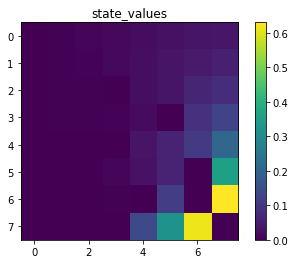

In [16]:
# Plot the action values.
# cliff walking
shape = (4,12,4)
# frozen lake
shape = (8,8,4)
#shape = (4,4,4)

plt.figure(0)
plt.imshow(agent._state_values.reshape(shape[:2]))
plt.colorbar(orientation='vertical')
plt.title("state_values")


# Summary

## Dynamic Programing

The most distinct things about DP is that:
1. the algorithm doesn't learn on the fly (i.e. while playing the game)! It learns the optimal policy and state values first, then play the game.
2. the algorithm requires **complete and accurate model of the environment**! As shown in the code above, it requires accessing the matrix env.P. For actual RL task, this is usually not possible because the environment is complicated and opaque.  

### Policy Iteration 

while (action not stable):
 - run policy evlaution until converge
   - this step iteratively find state value V(s) according to new policy V(s,a)
 - run policy improvement and check if action is stable
   - this step greedily update policy(action value) V(s, a) according to new state value
- check if actions are stable

### Value iteration
Simliar to policy iteration but with only one pass in policy evaluation. The result algorithm can be rewritten so that the policy improvement is implicit, resulting in a algorithm that only find the optimal state values, and not having the explicit optimal policy. 

During action, the optimal action needs to be found by evaluting the policy improvement on the current step. 

while (action not stable):
 - run value iteration  
   - this step iteratively update state value V_k+1(s) by the max state values found using state values from last step V_k(s)
- check if actions are stable 

NOTE:
discounting factor is necessary for learing the policy IF the environment only has reward at the end of episode. Otherwise the agent assign equal value for each state that leads to the reward.

